# Problem 1, Implementing a Neural Net from Scratch

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## A) Adding dataset

In [2]:
training_data = datasets.FashionMNIST(root="data", 
                                      train=True, 
                                      download=True, 
                                      transform=ToTensor())
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor())
labels_dict = {0:"T-shirt",
               1:"Trouser",
               2:"Pullover",
               3:"Dress",
               4:"Coat",
               5:"Sandal",
               6:"Shirt",
               7:"Sneaker",
               8:"Bag",
               9:"Ankle boot"}

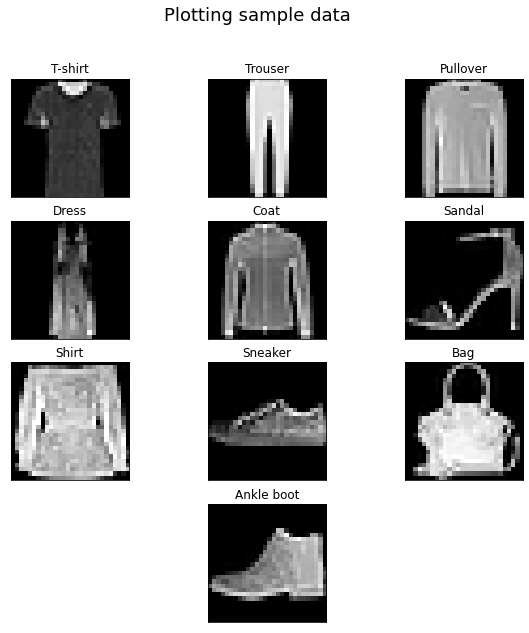

In [3]:
# get data sample
selected_imgs = torch.zeros((10, 1, 28, 28))
dl = DataLoader(training_data, batch_size=1000, shuffle=True)
data_subset = next(iter(dl))
for i in range(10):
    while(1):
        imgs_labels = data_subset[1]
        all_label_i = np.where(imgs_labels == i)[0]
        if len(all_label_i): 
            idx = np.random.choice(all_label_i, 1)
            selected_imgs[i, ...] = data_subset[0][idx].clone()
            break
        else:
            data_subset = next(iter(dl))

# plot sample data
fig, ax = plt.subplots(4, 3, figsize=(10,10))
fig.suptitle("Plotting sample data", fontsize=18)
fig.delaxes(ax[3, 0])
fig.delaxes(ax[3, 2])
for i in range(10):
    ax[i//3,i%3].set_xticks([])
    ax[i//3,i%3].set_yticks([])
    ax[i//3,i%3].imshow(selected_imgs[i, 0], cmap='gray')
    ax[i//3,i%3].set_title(labels_dict[i])
ax[3,1].set_xticks([])
ax[3,1].set_yticks([])
ax[3,1].imshow(selected_imgs[9, 0], cmap='gray')
ax[3,1].set_title(labels_dict[i])
plt.show()

## B) Implementing network

In [268]:
q = torch.randn((2, 3)) * np.sqrt(2/10)
print(q)

tensor([[ 0.1854, -0.0428, -0.4806],
        [-0.3088, -0.1572,  0.2935]])


In [269]:
# Layers implementation
class Linear:
    def __init__(self, input_neurons, output_neurons):
        self.n_i = input_neurons
        self.n_o = output_neurons
        # weights and bias intialization (He initialization)
        self.W = torch.randn((self.n_i, self.n_o))*np.sqrt(2/self.n_i)
        self.W.requires_grad_(True)
        self.b = torch.zeros((1, self.n_o), requires_grad=True)
    def __call__(self, X):
        return X @ self.W + self.b

class ReLU:
    def __call__(self, X):
        X[X <= 0] = 0
        return X

class Softmax():
    def __call__(self, X):
        exp_X = torch.exp(X)
        sum_exp_X = torch.sum(exp_X, axis=1, keepdim=True)
        return exp_X / sum_exp_X

class Flatten():
    def __call__(self, X):
        return X.reshape(X.shape[0], -1)

In [270]:
class Model:
    def __init__(self, batch_size, learning_reate):
        self.lr = learning_rate
        self.f = Flatten()
        self.l1 = Linear(28*28, 512)
        self.r1 = ReLU()
        # self.l2 = Linear(512, 512)
        # self.r2 = ReLU()
        self.l3 = Linear(512, 10)
        self.s = Softmax()
    def __call__(self, xb):
        yb = self.r1(self.l1(self.f(xb)))
        # yb = self.r2(self.l2(yb))
        yb = self.s(self.l3(yb))
        return yb
    def backward(self, loss):
        loss.backward()
        # print(self.l3.W[0:5, 0:5])
        # print(self.l3.b[0:5, 0:5])
        with torch.no_grad():
            self.l1.W += (-self.lr * self.l1.W.grad.clone())
            self.l1.b += (-self.lr * self.l1.b.grad.clone())
            # self.l2.W += (-self.lr * self.l2.W.grad.clone())
            # self.l2.b += (-self.lr * self.l2.b.grad.clone())
            self.l3.W += (-self.lr * self.l3.W.grad.clone())
            self.l3.b += (-self.lr * self.l3.b.grad.clone())
        # zero out gradients and set them true:
        self.l1.W.grad.zero_()
        self.l1.b.grad.zero_()
        # self.l2.W.grad.zero_()
        # self.l2.b.grad.zero_()
        self.l3.W.grad.zero_()
        self.l3.b.grad.zero_()

## C) Model training

In [271]:
def CrossEntropyLoss(pred, target):
    loss = 0
    for sample, label in enumerate(target):
        loss += (-torch.log(pred[sample, label]))
    loss /= len(target)
    return loss

In [272]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

model = Model(batch_size, learning_rate)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

for i in range(5):
    print(f"At epoch {i}")
    print("====================")
    size = len(train_dataloader.dataset)
    for batch, (Xb, train_labels) in enumerate(train_dataloader):
        # forward pass:
        yb = model(Xb)
        # calculate training loss
        loss_train = CrossEntropyLoss(yb, train_labels)
        # update parameters (SGD)
        model.backward(loss_train)
        
        if batch % 100 == 0:
            loss, current = loss_train.item(), batch * len(Xb)
            print(f"loss: {loss_train:>7f}  [{current:>5d}/{size:>5d}]")

At epoch 0
loss: 2.373948  [    0/60000]
loss: 1.902637  [ 6400/60000]
loss: 1.773077  [12800/60000]
loss: 1.648828  [19200/60000]
loss: 1.444443  [25600/60000]
loss: 1.481526  [32000/60000]
loss: 1.314581  [38400/60000]
loss: 1.232324  [44800/60000]
loss: 1.301935  [51200/60000]
loss: 1.057224  [57600/60000]
At epoch 1
loss: 1.156577  [    0/60000]
loss: 1.096489  [ 6400/60000]
loss: 0.928351  [12800/60000]
loss: 1.099867  [19200/60000]
loss: 0.977788  [25600/60000]
loss: 1.015385  [32000/60000]
loss: 1.002263  [38400/60000]
loss: 0.806742  [44800/60000]
loss: 0.924161  [51200/60000]
loss: 0.795905  [57600/60000]
At epoch 2
loss: 1.083409  [    0/60000]
loss: 0.884983  [ 6400/60000]
loss: 0.812409  [12800/60000]
loss: 0.962126  [19200/60000]
loss: 0.891164  [25600/60000]
loss: 0.772751  [32000/60000]
loss: 0.706937  [38400/60000]
loss: 0.961357  [44800/60000]
loss: 0.797855  [51200/60000]
loss: 0.780685  [57600/60000]
At epoch 3
loss: 0.859945  [    0/60000]
loss: 0.975745  [ 6400/600

KeyboardInterrupt: 